## Importing the necessary libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras import backend
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam

## Loading mnist dataset from keras

In [ ]:
from keras.datasets.mnist import load_data

In [ ]:
(x,y),(_,_)=load_data()

## Preparing the dataset


In [ ]:
def prepare_dataset(x_train,y_train):
  x_train=np.expand_dims(x,axis=3)
  x_train=(x.astype('float32')-127.5)/127.5
  return [x_train,y_train]

## Fetching some real samples from dataset

In [ ]:
def gen_real_samples(dataset,n_samples):
  x,labels=dataset
  indices=np.random.randint(0,x.shape[0],n_samples)
  x_train,labels= x[indices],labels[indices]
  y=np.ones((n_samples,1))
  return [x_train,labels],y

## Getting latent vector from latent space

In [ ]:
def get_latent_vector(n_samples,dimension,n_classes=10):
  points=np.random.randn(n_samples*dimension)
  points=points.reshape(n_samples,dimension)
  labels=np.random.randint(0,n_classes,n_samples)
  return [points,labels]

## Getting fake samples by passing latent vector

In [ ]:
def gen_fake_samples(generator,n_samples,latent_dimension):
  latent_vector,labels=get_latent_vector(n_samples,latent_dimension)
  image=generator.predict([latent_vector,labels])
  y=np.zeros((n_samples,1))
  return [image,labels],y

## Discriminator Model for classification

In [ ]:
def discriminator(input_shape=(28,28,1),n_classes=10):
  inp1=Input(shape=(1,))
  ao=Embedding(n_classes,50)(inp1)
  nodes = input_shape[0] * input_shape[1]
  ao=Dense(nodes)(ao)
  ao=Reshape((input_shape[0],input_shape[1],1))(ao)
  inp2=Input(shape=input_shape)
  conc=Concatenate()([inp2,ao])
  fl=Conv2D(128,3,2,padding='same')(conc)
  fl=LeakyReLU(alpha=0.2)(fl)
  fl=Conv2D(128,3,2,padding='same')(fl)
  fl=LeakyReLU(alpha=0.2)(fl)
  fl=Flatten()(fl)
  fl=Dropout(0.4)(fl)
  last=Dense(1,activation='sigmoid')(fl)
  model=Model([inp2,inp1],last)
  opt=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
  model.summary()
  return model


In [ ]:
disc_model=discriminator()

Model: "model_86"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_115 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 embedding_57 (Embedding)       (None, 1, 50)        500         ['input_115[0][0]']              
                                                                                                  
 dense_114 (Dense)              (None, 1, 784)       39984       ['embedding_57[0][0]']           
                                                                                                  
 input_116 (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                           

## Generator Model for gerating fake images from noise

In [ ]:
def generator(latent_dimension,n_classes=10):
  inp1=Input(shape=(1,))
  ol=Embedding(n_classes,50)(inp1)
  nodes=7*7
  ol=Dense(nodes)(ol)
  ol=Reshape((7,7,1))(ol)
  inp2=Input(shape=(latent_dimension,))
  nodes=128*7*7
  fl=Dense(nodes)(inp2)
  fl=LeakyReLU(alpha=0.2)(fl)
  fl=Reshape((7,7,128))(fl)
  concat=Concatenate()([fl,ol])
  conv=Conv2DTranspose(128,4,2,padding='same')(concat)
  conv=LeakyReLU(alpha=0.2)(conv)
  conv=Conv2DTranspose(128,4,2,padding='same')(conv)
  conv=LeakyReLU(alpha=0.2)(conv)
  last=Conv2D(1,(7,7),activation='tanh',padding='same')(conv)
  model=Model([inp2,inp1],last)
  return model


## GAN Model


In [ ]:
def gan(gen,disc):
  disc.trainable=False
  latent_vector,label=gen.input
  gen_output=gen.output
  gan_output=disc([gen_output,label])
  model = Model([latent_vector,label], gan_output)
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

## Training of GAN

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # Manually enumerate epochs
    for i in range(n_epochs):
        # Enumerate batches over the training set
        for j in range(bat_per_epo):
            # Get randomly selected 'real' samples
            [X_real, labels_real], y_real = gen_real_samples(dataset, half_batch)

            # Update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            # Generate 'fake' examples
            [X_fake, labels], y_fake = gen_fake_samples(g_model, half_batch, latent_dim)

            # Update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            # Prepare points in latent space as input for the generator
            [z_input, labels_input] = get_latent_vector( n_batch,latent_dim)

            # Create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # Summarize loss on this batch
            print('>Epoch: %d,Batch: %d/%d, disc_real_loss=%.3f, disc_fake_loss=%.3f gan_loss=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

            if (i+1)%5==0:
                # Save the generator model
              g_model.save('cgan_generator.h5')


In [ ]:
model = keras.models.load_model('cgan_generator.h5')

In [ ]:
latent_dim=100
gen_model = generator(latent_dimension=latent_dim)
gan_model = gan(gen_model, disc_model)
dataset = prepare_dataset(x,y)
train(model, disc_model, gan_model, dataset, latent_dim)

2/2 [==============================] - 0s 6ms/step
>Epoch: 1,Batch: 1/468, disc_real_loss=0.000, disc_fake_loss=12.401 gan_loss=5.532
2/2 [==============================] - 0s 6ms/step
>Epoch: 1,Batch: 2/468, disc_real_loss=0.038, disc_fake_loss=6.479 gan_loss=5.916
2/2 [==============================] - 0s 5ms/step
>Epoch: 1,Batch: 3/468, disc_real_loss=0.414, disc_fake_loss=2.045 gan_loss=6.015
2/2 [==============================] - 0s 6ms/step
>Epoch: 1,Batch: 4/468, disc_real_loss=2.206, disc_fake_loss=0.922 gan_loss=5.644
2/2 [==============================] - 0s 4ms/step
>Epoch: 1,Batch: 5/468, disc_real_loss=1.725, disc_fake_loss=1.140 gan_loss=5.484
2/2 [==============================] - 0s 5ms/step
>Epoch: 1,Batch: 6/468, disc_real_loss=0.881, disc_fake_loss=1.001 gan_loss=5.562
2/2 [==============================] - 0s 4ms/step
>Epoch: 1,Batch: 7/468, disc_real_loss=0.913, disc_fake_loss=0.981 gan_loss=5.498
2/2 [==============================] - 0s 5ms/step
>Epoch: 1,Batch: 

>Epoch: 5,Batch: 1/468, disc_real_loss=0.221, disc_fake_loss=0.335 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 2/468, disc_real_loss=0.387, disc_fake_loss=0.285 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 3/468, disc_real_loss=0.328, disc_fake_loss=0.342 gan_loss=0.000
2/2 [==============================] - 0s 4ms/step


>Epoch: 5,Batch: 4/468, disc_real_loss=0.304, disc_fake_loss=0.324 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 5/468, disc_real_loss=0.396, disc_fake_loss=0.314 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 6/468, disc_real_loss=0.271, disc_fake_loss=0.343 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 7/468, disc_real_loss=0.283, disc_fake_loss=0.289 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 8/468, disc_real_loss=0.393, disc_fake_loss=0.351 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 9/468, disc_real_loss=0.387, disc_fake_loss=0.459 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 10/468, disc_real_loss=0.313, disc_fake_loss=0.320 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 11/468, disc_real_loss=0.337, disc_fake_loss=0.452 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 12/468, disc_real_loss=0.242, disc_fake_loss=0.294 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 13/468, disc_real_loss=0.310, disc_fake_loss=0.361 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 14/468, disc_real_loss=0.423, disc_fake_loss=0.289 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 15/468, disc_real_loss=0.422, disc_fake_loss=0.395 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 16/468, disc_real_loss=0.296, disc_fake_loss=0.336 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 17/468, disc_real_loss=0.352, disc_fake_loss=0.390 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 18/468, disc_real_loss=0.342, disc_fake_loss=0.357 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 19/468, disc_real_loss=0.290, disc_fake_loss=0.306 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 20/468, disc_real_loss=0.251, disc_fake_loss=0.337 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 21/468, disc_real_loss=0.371, disc_fake_loss=0.288 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 22/468, disc_real_loss=0.384, disc_fake_loss=0.301 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 23/468, disc_real_loss=0.374, disc_fake_loss=0.365 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 24/468, disc_real_loss=0.279, disc_fake_loss=0.405 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 25/468, disc_real_loss=0.279, disc_fake_loss=0.392 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 26/468, disc_real_loss=0.310, disc_fake_loss=0.296 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 27/468, disc_real_loss=0.466, disc_fake_loss=0.274 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 28/468, disc_real_loss=0.414, disc_fake_loss=0.344 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 29/468, disc_real_loss=0.294, disc_fake_loss=0.440 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 30/468, disc_real_loss=0.248, disc_fake_loss=0.325 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 31/468, disc_real_loss=0.390, disc_fake_loss=0.382 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 32/468, disc_real_loss=0.287, disc_fake_loss=0.318 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 33/468, disc_real_loss=0.314, disc_fake_loss=0.408 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 34/468, disc_real_loss=0.401, disc_fake_loss=0.312 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 35/468, disc_real_loss=0.315, disc_fake_loss=0.260 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 36/468, disc_real_loss=0.406, disc_fake_loss=0.410 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 37/468, disc_real_loss=0.344, disc_fake_loss=0.291 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 38/468, disc_real_loss=0.334, disc_fake_loss=0.363 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 39/468, disc_real_loss=0.265, disc_fake_loss=0.373 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 40/468, disc_real_loss=0.335, disc_fake_loss=0.262 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 41/468, disc_real_loss=0.475, disc_fake_loss=0.421 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 42/468, disc_real_loss=0.257, disc_fake_loss=0.358 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 43/468, disc_real_loss=0.341, disc_fake_loss=0.337 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 44/468, disc_real_loss=0.314, disc_fake_loss=0.377 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 45/468, disc_real_loss=0.306, disc_fake_loss=0.362 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 46/468, disc_real_loss=0.388, disc_fake_loss=0.330 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 47/468, disc_real_loss=0.307, disc_fake_loss=0.357 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 48/468, disc_real_loss=0.324, disc_fake_loss=0.370 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 49/468, disc_real_loss=0.411, disc_fake_loss=0.312 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 50/468, disc_real_loss=0.372, disc_fake_loss=0.353 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 51/468, disc_real_loss=0.351, disc_fake_loss=0.317 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 52/468, disc_real_loss=0.309, disc_fake_loss=0.516 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 53/468, disc_real_loss=0.309, disc_fake_loss=0.308 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 54/468, disc_real_loss=0.407, disc_fake_loss=0.282 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 55/468, disc_real_loss=0.389, disc_fake_loss=0.317 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 56/468, disc_real_loss=0.383, disc_fake_loss=0.418 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 57/468, disc_real_loss=0.292, disc_fake_loss=0.350 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 58/468, disc_real_loss=0.355, disc_fake_loss=0.361 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 59/468, disc_real_loss=0.307, disc_fake_loss=0.287 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 60/468, disc_real_loss=0.296, disc_fake_loss=0.242 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 61/468, disc_real_loss=0.338, disc_fake_loss=0.374 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 62/468, disc_real_loss=0.336, disc_fake_loss=0.337 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 63/468, disc_real_loss=0.329, disc_fake_loss=0.265 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 64/468, disc_real_loss=0.298, disc_fake_loss=0.408 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 65/468, disc_real_loss=0.400, disc_fake_loss=0.286 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 66/468, disc_real_loss=0.297, disc_fake_loss=0.441 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 67/468, disc_real_loss=0.349, disc_fake_loss=0.355 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 68/468, disc_real_loss=0.257, disc_fake_loss=0.367 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 69/468, disc_real_loss=0.356, disc_fake_loss=0.290 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 70/468, disc_real_loss=0.435, disc_fake_loss=0.373 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 71/468, disc_real_loss=0.246, disc_fake_loss=0.327 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 72/468, disc_real_loss=0.420, disc_fake_loss=0.382 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 73/468, disc_real_loss=0.322, disc_fake_loss=0.345 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 74/468, disc_real_loss=0.357, disc_fake_loss=0.309 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 75/468, disc_real_loss=0.371, disc_fake_loss=0.477 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 76/468, disc_real_loss=0.356, disc_fake_loss=0.380 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 77/468, disc_real_loss=0.323, disc_fake_loss=0.298 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 78/468, disc_real_loss=0.245, disc_fake_loss=0.323 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 79/468, disc_real_loss=0.323, disc_fake_loss=0.301 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 80/468, disc_real_loss=0.368, disc_fake_loss=0.331 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 81/468, disc_real_loss=0.369, disc_fake_loss=0.276 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 82/468, disc_real_loss=0.426, disc_fake_loss=0.344 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 83/468, disc_real_loss=0.233, disc_fake_loss=0.331 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 84/468, disc_real_loss=0.255, disc_fake_loss=0.316 gan_loss=0.000
2/2 [==============================] - 0s 4ms/step


>Epoch: 5,Batch: 85/468, disc_real_loss=0.388, disc_fake_loss=0.276 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 86/468, disc_real_loss=0.322, disc_fake_loss=0.357 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 87/468, disc_real_loss=0.243, disc_fake_loss=0.296 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 88/468, disc_real_loss=0.223, disc_fake_loss=0.272 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 89/468, disc_real_loss=0.342, disc_fake_loss=0.321 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 90/468, disc_real_loss=0.350, disc_fake_loss=0.355 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 91/468, disc_real_loss=0.476, disc_fake_loss=0.335 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 92/468, disc_real_loss=0.326, disc_fake_loss=0.315 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 93/468, disc_real_loss=0.285, disc_fake_loss=0.332 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 94/468, disc_real_loss=0.295, disc_fake_loss=0.389 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 95/468, disc_real_loss=0.394, disc_fake_loss=0.483 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 96/468, disc_real_loss=0.338, disc_fake_loss=0.255 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 97/468, disc_real_loss=0.366, disc_fake_loss=0.360 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 98/468, disc_real_loss=0.270, disc_fake_loss=0.228 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 99/468, disc_real_loss=0.343, disc_fake_loss=0.340 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 100/468, disc_real_loss=0.306, disc_fake_loss=0.386 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 101/468, disc_real_loss=0.282, disc_fake_loss=0.371 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 102/468, disc_real_loss=0.327, disc_fake_loss=0.287 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 103/468, disc_real_loss=0.308, disc_fake_loss=0.348 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 104/468, disc_real_loss=0.297, disc_fake_loss=0.284 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 105/468, disc_real_loss=0.400, disc_fake_loss=0.314 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 106/468, disc_real_loss=0.382, disc_fake_loss=0.323 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 107/468, disc_real_loss=0.352, disc_fake_loss=0.347 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 108/468, disc_real_loss=0.338, disc_fake_loss=0.316 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 109/468, disc_real_loss=0.376, disc_fake_loss=0.412 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 110/468, disc_real_loss=0.246, disc_fake_loss=0.305 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 111/468, disc_real_loss=0.268, disc_fake_loss=0.338 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 112/468, disc_real_loss=0.341, disc_fake_loss=0.337 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 113/468, disc_real_loss=0.318, disc_fake_loss=0.283 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 114/468, disc_real_loss=0.396, disc_fake_loss=0.348 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 115/468, disc_real_loss=0.389, disc_fake_loss=0.373 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 116/468, disc_real_loss=0.324, disc_fake_loss=0.315 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 117/468, disc_real_loss=0.291, disc_fake_loss=0.349 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 118/468, disc_real_loss=0.353, disc_fake_loss=0.378 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 119/468, disc_real_loss=0.370, disc_fake_loss=0.231 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 120/468, disc_real_loss=0.355, disc_fake_loss=0.394 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 121/468, disc_real_loss=0.244, disc_fake_loss=0.362 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 122/468, disc_real_loss=0.325, disc_fake_loss=0.299 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 123/468, disc_real_loss=0.340, disc_fake_loss=0.299 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 124/468, disc_real_loss=0.307, disc_fake_loss=0.335 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 125/468, disc_real_loss=0.354, disc_fake_loss=0.350 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 126/468, disc_real_loss=0.318, disc_fake_loss=0.400 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 127/468, disc_real_loss=0.371, disc_fake_loss=0.405 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 128/468, disc_real_loss=0.385, disc_fake_loss=0.340 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 129/468, disc_real_loss=0.368, disc_fake_loss=0.427 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 130/468, disc_real_loss=0.269, disc_fake_loss=0.363 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 131/468, disc_real_loss=0.382, disc_fake_loss=0.292 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 132/468, disc_real_loss=0.336, disc_fake_loss=0.323 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 133/468, disc_real_loss=0.270, disc_fake_loss=0.353 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 134/468, disc_real_loss=0.264, disc_fake_loss=0.291 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 135/468, disc_real_loss=0.481, disc_fake_loss=0.362 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 136/468, disc_real_loss=0.326, disc_fake_loss=0.302 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 137/468, disc_real_loss=0.332, disc_fake_loss=0.382 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 138/468, disc_real_loss=0.351, disc_fake_loss=0.338 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 139/468, disc_real_loss=0.325, disc_fake_loss=0.300 gan_loss=0.000
2/2 [==============================] - 0s 4ms/step


>Epoch: 5,Batch: 140/468, disc_real_loss=0.342, disc_fake_loss=0.469 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 141/468, disc_real_loss=0.268, disc_fake_loss=0.344 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 142/468, disc_real_loss=0.312, disc_fake_loss=0.206 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 143/468, disc_real_loss=0.342, disc_fake_loss=0.326 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 144/468, disc_real_loss=0.308, disc_fake_loss=0.336 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 145/468, disc_real_loss=0.295, disc_fake_loss=0.375 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 146/468, disc_real_loss=0.371, disc_fake_loss=0.353 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 147/468, disc_real_loss=0.302, disc_fake_loss=0.260 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 148/468, disc_real_loss=0.302, disc_fake_loss=0.448 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 149/468, disc_real_loss=0.258, disc_fake_loss=0.285 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 150/468, disc_real_loss=0.474, disc_fake_loss=0.400 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 151/468, disc_real_loss=0.318, disc_fake_loss=0.293 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 152/468, disc_real_loss=0.305, disc_fake_loss=0.298 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 153/468, disc_real_loss=0.339, disc_fake_loss=0.368 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 154/468, disc_real_loss=0.334, disc_fake_loss=0.334 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 155/468, disc_real_loss=0.272, disc_fake_loss=0.358 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 156/468, disc_real_loss=0.468, disc_fake_loss=0.325 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 157/468, disc_real_loss=0.334, disc_fake_loss=0.308 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 158/468, disc_real_loss=0.280, disc_fake_loss=0.331 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 159/468, disc_real_loss=0.323, disc_fake_loss=0.343 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 160/468, disc_real_loss=0.367, disc_fake_loss=0.373 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 161/468, disc_real_loss=0.277, disc_fake_loss=0.315 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 162/468, disc_real_loss=0.274, disc_fake_loss=0.322 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 163/468, disc_real_loss=0.343, disc_fake_loss=0.331 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 164/468, disc_real_loss=0.393, disc_fake_loss=0.326 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 165/468, disc_real_loss=0.347, disc_fake_loss=0.267 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 166/468, disc_real_loss=0.345, disc_fake_loss=0.346 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 167/468, disc_real_loss=0.295, disc_fake_loss=0.306 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 168/468, disc_real_loss=0.328, disc_fake_loss=0.423 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 169/468, disc_real_loss=0.374, disc_fake_loss=0.321 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 170/468, disc_real_loss=0.367, disc_fake_loss=0.319 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 171/468, disc_real_loss=0.364, disc_fake_loss=0.424 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 172/468, disc_real_loss=0.305, disc_fake_loss=0.311 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 173/468, disc_real_loss=0.296, disc_fake_loss=0.322 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 174/468, disc_real_loss=0.391, disc_fake_loss=0.395 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 175/468, disc_real_loss=0.268, disc_fake_loss=0.289 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 176/468, disc_real_loss=0.296, disc_fake_loss=0.406 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 177/468, disc_real_loss=0.361, disc_fake_loss=0.269 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 178/468, disc_real_loss=0.362, disc_fake_loss=0.320 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 179/468, disc_real_loss=0.280, disc_fake_loss=0.264 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 180/468, disc_real_loss=0.252, disc_fake_loss=0.320 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 181/468, disc_real_loss=0.448, disc_fake_loss=0.275 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 182/468, disc_real_loss=0.265, disc_fake_loss=0.297 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 183/468, disc_real_loss=0.246, disc_fake_loss=0.340 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 184/468, disc_real_loss=0.247, disc_fake_loss=0.301 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 185/468, disc_real_loss=0.327, disc_fake_loss=0.355 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 186/468, disc_real_loss=0.311, disc_fake_loss=0.357 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 187/468, disc_real_loss=0.340, disc_fake_loss=0.302 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 188/468, disc_real_loss=0.330, disc_fake_loss=0.341 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 189/468, disc_real_loss=0.336, disc_fake_loss=0.310 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 190/468, disc_real_loss=0.417, disc_fake_loss=0.381 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 191/468, disc_real_loss=0.230, disc_fake_loss=0.444 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 192/468, disc_real_loss=0.397, disc_fake_loss=0.275 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 193/468, disc_real_loss=0.339, disc_fake_loss=0.259 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 194/468, disc_real_loss=0.305, disc_fake_loss=0.285 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 195/468, disc_real_loss=0.362, disc_fake_loss=0.347 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 196/468, disc_real_loss=0.364, disc_fake_loss=0.304 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 197/468, disc_real_loss=0.258, disc_fake_loss=0.403 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 198/468, disc_real_loss=0.249, disc_fake_loss=0.280 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 199/468, disc_real_loss=0.304, disc_fake_loss=0.282 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 200/468, disc_real_loss=0.227, disc_fake_loss=0.377 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 201/468, disc_real_loss=0.429, disc_fake_loss=0.281 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 202/468, disc_real_loss=0.327, disc_fake_loss=0.232 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 203/468, disc_real_loss=0.357, disc_fake_loss=0.424 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 204/468, disc_real_loss=0.376, disc_fake_loss=0.396 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 205/468, disc_real_loss=0.252, disc_fake_loss=0.298 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 206/468, disc_real_loss=0.335, disc_fake_loss=0.221 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 207/468, disc_real_loss=0.298, disc_fake_loss=0.347 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 208/468, disc_real_loss=0.341, disc_fake_loss=0.306 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 209/468, disc_real_loss=0.341, disc_fake_loss=0.278 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 210/468, disc_real_loss=0.297, disc_fake_loss=0.403 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 211/468, disc_real_loss=0.327, disc_fake_loss=0.202 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 212/468, disc_real_loss=0.292, disc_fake_loss=0.314 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 213/468, disc_real_loss=0.255, disc_fake_loss=0.249 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 214/468, disc_real_loss=0.317, disc_fake_loss=0.364 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 215/468, disc_real_loss=0.396, disc_fake_loss=0.330 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 216/468, disc_real_loss=0.281, disc_fake_loss=0.351 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 217/468, disc_real_loss=0.385, disc_fake_loss=0.317 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 218/468, disc_real_loss=0.298, disc_fake_loss=0.286 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 219/468, disc_real_loss=0.273, disc_fake_loss=0.280 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 220/468, disc_real_loss=0.294, disc_fake_loss=0.348 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 221/468, disc_real_loss=0.226, disc_fake_loss=0.239 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 222/468, disc_real_loss=0.297, disc_fake_loss=0.311 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 223/468, disc_real_loss=0.343, disc_fake_loss=0.235 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 224/468, disc_real_loss=0.333, disc_fake_loss=0.392 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 225/468, disc_real_loss=0.283, disc_fake_loss=0.369 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 226/468, disc_real_loss=0.352, disc_fake_loss=0.255 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 227/468, disc_real_loss=0.305, disc_fake_loss=0.321 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 228/468, disc_real_loss=0.363, disc_fake_loss=0.350 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 229/468, disc_real_loss=0.258, disc_fake_loss=0.350 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 230/468, disc_real_loss=0.358, disc_fake_loss=0.282 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 231/468, disc_real_loss=0.263, disc_fake_loss=0.355 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 232/468, disc_real_loss=0.350, disc_fake_loss=0.399 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 233/468, disc_real_loss=0.321, disc_fake_loss=0.329 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 234/468, disc_real_loss=0.334, disc_fake_loss=0.399 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 235/468, disc_real_loss=0.354, disc_fake_loss=0.308 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 236/468, disc_real_loss=0.346, disc_fake_loss=0.296 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 237/468, disc_real_loss=0.303, disc_fake_loss=0.289 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 238/468, disc_real_loss=0.401, disc_fake_loss=0.384 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 239/468, disc_real_loss=0.439, disc_fake_loss=0.369 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 240/468, disc_real_loss=0.294, disc_fake_loss=0.371 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 241/468, disc_real_loss=0.386, disc_fake_loss=0.392 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 242/468, disc_real_loss=0.340, disc_fake_loss=0.329 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 243/468, disc_real_loss=0.370, disc_fake_loss=0.486 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 244/468, disc_real_loss=0.368, disc_fake_loss=0.338 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 245/468, disc_real_loss=0.248, disc_fake_loss=0.251 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 246/468, disc_real_loss=0.276, disc_fake_loss=0.281 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 247/468, disc_real_loss=0.256, disc_fake_loss=0.208 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 248/468, disc_real_loss=0.292, disc_fake_loss=0.353 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 249/468, disc_real_loss=0.369, disc_fake_loss=0.344 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 250/468, disc_real_loss=0.235, disc_fake_loss=0.357 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 251/468, disc_real_loss=0.337, disc_fake_loss=0.265 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 252/468, disc_real_loss=0.274, disc_fake_loss=0.368 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 253/468, disc_real_loss=0.397, disc_fake_loss=0.263 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 254/468, disc_real_loss=0.252, disc_fake_loss=0.272 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 255/468, disc_real_loss=0.379, disc_fake_loss=0.309 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 256/468, disc_real_loss=0.306, disc_fake_loss=0.360 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 257/468, disc_real_loss=0.370, disc_fake_loss=0.335 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 258/468, disc_real_loss=0.333, disc_fake_loss=0.371 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 259/468, disc_real_loss=0.349, disc_fake_loss=0.314 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 260/468, disc_real_loss=0.285, disc_fake_loss=0.359 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 261/468, disc_real_loss=0.288, disc_fake_loss=0.358 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 262/468, disc_real_loss=0.313, disc_fake_loss=0.264 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 263/468, disc_real_loss=0.261, disc_fake_loss=0.306 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 264/468, disc_real_loss=0.288, disc_fake_loss=0.284 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 265/468, disc_real_loss=0.302, disc_fake_loss=0.291 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 266/468, disc_real_loss=0.399, disc_fake_loss=0.314 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 267/468, disc_real_loss=0.236, disc_fake_loss=0.306 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 268/468, disc_real_loss=0.296, disc_fake_loss=0.361 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 269/468, disc_real_loss=0.322, disc_fake_loss=0.338 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 270/468, disc_real_loss=0.329, disc_fake_loss=0.351 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 271/468, disc_real_loss=0.372, disc_fake_loss=0.238 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 272/468, disc_real_loss=0.362, disc_fake_loss=0.337 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 273/468, disc_real_loss=0.291, disc_fake_loss=0.348 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 274/468, disc_real_loss=0.340, disc_fake_loss=0.326 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 275/468, disc_real_loss=0.337, disc_fake_loss=0.282 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 276/468, disc_real_loss=0.382, disc_fake_loss=0.300 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 277/468, disc_real_loss=0.372, disc_fake_loss=0.371 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 278/468, disc_real_loss=0.230, disc_fake_loss=0.327 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 279/468, disc_real_loss=0.301, disc_fake_loss=0.353 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 280/468, disc_real_loss=0.330, disc_fake_loss=0.272 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 281/468, disc_real_loss=0.324, disc_fake_loss=0.262 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 282/468, disc_real_loss=0.280, disc_fake_loss=0.273 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 283/468, disc_real_loss=0.349, disc_fake_loss=0.322 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 284/468, disc_real_loss=0.212, disc_fake_loss=0.373 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 285/468, disc_real_loss=0.262, disc_fake_loss=0.262 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 286/468, disc_real_loss=0.308, disc_fake_loss=0.264 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 287/468, disc_real_loss=0.291, disc_fake_loss=0.311 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 288/468, disc_real_loss=0.416, disc_fake_loss=0.379 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 289/468, disc_real_loss=0.329, disc_fake_loss=0.343 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 290/468, disc_real_loss=0.389, disc_fake_loss=0.293 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 291/468, disc_real_loss=0.305, disc_fake_loss=0.278 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 292/468, disc_real_loss=0.313, disc_fake_loss=0.438 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 293/468, disc_real_loss=0.319, disc_fake_loss=0.282 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 294/468, disc_real_loss=0.347, disc_fake_loss=0.376 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 295/468, disc_real_loss=0.374, disc_fake_loss=0.305 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 296/468, disc_real_loss=0.323, disc_fake_loss=0.405 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 297/468, disc_real_loss=0.363, disc_fake_loss=0.336 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 298/468, disc_real_loss=0.343, disc_fake_loss=0.326 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 299/468, disc_real_loss=0.320, disc_fake_loss=0.278 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 300/468, disc_real_loss=0.364, disc_fake_loss=0.371 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 301/468, disc_real_loss=0.355, disc_fake_loss=0.268 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 302/468, disc_real_loss=0.293, disc_fake_loss=0.374 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 303/468, disc_real_loss=0.288, disc_fake_loss=0.396 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 304/468, disc_real_loss=0.305, disc_fake_loss=0.358 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 305/468, disc_real_loss=0.302, disc_fake_loss=0.249 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 306/468, disc_real_loss=0.275, disc_fake_loss=0.293 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 307/468, disc_real_loss=0.425, disc_fake_loss=0.288 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 308/468, disc_real_loss=0.227, disc_fake_loss=0.320 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 309/468, disc_real_loss=0.317, disc_fake_loss=0.309 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 310/468, disc_real_loss=0.218, disc_fake_loss=0.285 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 311/468, disc_real_loss=0.258, disc_fake_loss=0.362 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 312/468, disc_real_loss=0.303, disc_fake_loss=0.329 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 313/468, disc_real_loss=0.384, disc_fake_loss=0.265 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 314/468, disc_real_loss=0.277, disc_fake_loss=0.305 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 315/468, disc_real_loss=0.270, disc_fake_loss=0.257 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 316/468, disc_real_loss=0.362, disc_fake_loss=0.294 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 317/468, disc_real_loss=0.231, disc_fake_loss=0.288 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 318/468, disc_real_loss=0.238, disc_fake_loss=0.323 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 319/468, disc_real_loss=0.385, disc_fake_loss=0.311 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 320/468, disc_real_loss=0.304, disc_fake_loss=0.347 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 321/468, disc_real_loss=0.249, disc_fake_loss=0.360 gan_loss=0.000
2/2 [==============================] - 0s 4ms/step


>Epoch: 5,Batch: 322/468, disc_real_loss=0.294, disc_fake_loss=0.346 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 323/468, disc_real_loss=0.406, disc_fake_loss=0.244 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 324/468, disc_real_loss=0.323, disc_fake_loss=0.313 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 325/468, disc_real_loss=0.233, disc_fake_loss=0.280 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 326/468, disc_real_loss=0.344, disc_fake_loss=0.340 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 327/468, disc_real_loss=0.339, disc_fake_loss=0.378 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 328/468, disc_real_loss=0.351, disc_fake_loss=0.360 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 329/468, disc_real_loss=0.357, disc_fake_loss=0.278 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 330/468, disc_real_loss=0.278, disc_fake_loss=0.421 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 331/468, disc_real_loss=0.266, disc_fake_loss=0.300 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 332/468, disc_real_loss=0.379, disc_fake_loss=0.213 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 333/468, disc_real_loss=0.330, disc_fake_loss=0.264 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 334/468, disc_real_loss=0.226, disc_fake_loss=0.344 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 335/468, disc_real_loss=0.263, disc_fake_loss=0.294 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 336/468, disc_real_loss=0.333, disc_fake_loss=0.313 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 337/468, disc_real_loss=0.321, disc_fake_loss=0.347 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 338/468, disc_real_loss=0.279, disc_fake_loss=0.325 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 339/468, disc_real_loss=0.372, disc_fake_loss=0.269 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 340/468, disc_real_loss=0.350, disc_fake_loss=0.285 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 341/468, disc_real_loss=0.321, disc_fake_loss=0.268 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 342/468, disc_real_loss=0.230, disc_fake_loss=0.378 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 343/468, disc_real_loss=0.352, disc_fake_loss=0.315 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 344/468, disc_real_loss=0.393, disc_fake_loss=0.443 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 345/468, disc_real_loss=0.275, disc_fake_loss=0.352 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 346/468, disc_real_loss=0.417, disc_fake_loss=0.275 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 347/468, disc_real_loss=0.380, disc_fake_loss=0.485 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 348/468, disc_real_loss=0.298, disc_fake_loss=0.278 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 349/468, disc_real_loss=0.334, disc_fake_loss=0.339 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 350/468, disc_real_loss=0.318, disc_fake_loss=0.311 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 351/468, disc_real_loss=0.247, disc_fake_loss=0.352 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 352/468, disc_real_loss=0.350, disc_fake_loss=0.256 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 353/468, disc_real_loss=0.278, disc_fake_loss=0.244 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 354/468, disc_real_loss=0.329, disc_fake_loss=0.351 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 355/468, disc_real_loss=0.265, disc_fake_loss=0.296 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 356/468, disc_real_loss=0.336, disc_fake_loss=0.407 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 357/468, disc_real_loss=0.273, disc_fake_loss=0.292 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 358/468, disc_real_loss=0.348, disc_fake_loss=0.290 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 359/468, disc_real_loss=0.454, disc_fake_loss=0.419 gan_loss=0.000
2/2 [==============================] - 0s 14ms/step


>Epoch: 5,Batch: 360/468, disc_real_loss=0.308, disc_fake_loss=0.383 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 361/468, disc_real_loss=0.314, disc_fake_loss=0.249 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 362/468, disc_real_loss=0.241, disc_fake_loss=0.360 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 363/468, disc_real_loss=0.303, disc_fake_loss=0.382 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 364/468, disc_real_loss=0.270, disc_fake_loss=0.290 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 365/468, disc_real_loss=0.464, disc_fake_loss=0.335 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 366/468, disc_real_loss=0.431, disc_fake_loss=0.277 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 367/468, disc_real_loss=0.235, disc_fake_loss=0.340 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 368/468, disc_real_loss=0.201, disc_fake_loss=0.259 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 369/468, disc_real_loss=0.271, disc_fake_loss=0.321 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 370/468, disc_real_loss=0.307, disc_fake_loss=0.349 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 371/468, disc_real_loss=0.340, disc_fake_loss=0.203 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 372/468, disc_real_loss=0.471, disc_fake_loss=0.450 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 373/468, disc_real_loss=0.320, disc_fake_loss=0.411 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 374/468, disc_real_loss=0.308, disc_fake_loss=0.294 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 375/468, disc_real_loss=0.311, disc_fake_loss=0.324 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 376/468, disc_real_loss=0.287, disc_fake_loss=0.276 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 377/468, disc_real_loss=0.335, disc_fake_loss=0.238 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 378/468, disc_real_loss=0.339, disc_fake_loss=0.331 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 379/468, disc_real_loss=0.372, disc_fake_loss=0.380 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 380/468, disc_real_loss=0.283, disc_fake_loss=0.379 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 381/468, disc_real_loss=0.249, disc_fake_loss=0.244 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 382/468, disc_real_loss=0.362, disc_fake_loss=0.323 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 383/468, disc_real_loss=0.366, disc_fake_loss=0.286 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 384/468, disc_real_loss=0.269, disc_fake_loss=0.329 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 385/468, disc_real_loss=0.287, disc_fake_loss=0.286 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 386/468, disc_real_loss=0.258, disc_fake_loss=0.321 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 387/468, disc_real_loss=0.346, disc_fake_loss=0.341 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 388/468, disc_real_loss=0.242, disc_fake_loss=0.362 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 389/468, disc_real_loss=0.365, disc_fake_loss=0.243 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 390/468, disc_real_loss=0.315, disc_fake_loss=0.258 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 391/468, disc_real_loss=0.312, disc_fake_loss=0.358 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 392/468, disc_real_loss=0.246, disc_fake_loss=0.316 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 393/468, disc_real_loss=0.228, disc_fake_loss=0.290 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 394/468, disc_real_loss=0.316, disc_fake_loss=0.319 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 395/468, disc_real_loss=0.262, disc_fake_loss=0.204 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 396/468, disc_real_loss=0.295, disc_fake_loss=0.366 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 397/468, disc_real_loss=0.298, disc_fake_loss=0.305 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 398/468, disc_real_loss=0.273, disc_fake_loss=0.394 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 399/468, disc_real_loss=0.368, disc_fake_loss=0.270 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 400/468, disc_real_loss=0.256, disc_fake_loss=0.337 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 401/468, disc_real_loss=0.316, disc_fake_loss=0.327 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 402/468, disc_real_loss=0.379, disc_fake_loss=0.245 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 403/468, disc_real_loss=0.293, disc_fake_loss=0.325 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 404/468, disc_real_loss=0.269, disc_fake_loss=0.302 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 405/468, disc_real_loss=0.307, disc_fake_loss=0.287 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 406/468, disc_real_loss=0.291, disc_fake_loss=0.344 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 407/468, disc_real_loss=0.331, disc_fake_loss=0.348 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 408/468, disc_real_loss=0.325, disc_fake_loss=0.241 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 409/468, disc_real_loss=0.282, disc_fake_loss=0.360 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 410/468, disc_real_loss=0.200, disc_fake_loss=0.239 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 411/468, disc_real_loss=0.262, disc_fake_loss=0.333 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 412/468, disc_real_loss=0.385, disc_fake_loss=0.264 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 413/468, disc_real_loss=0.399, disc_fake_loss=0.358 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 414/468, disc_real_loss=0.301, disc_fake_loss=0.380 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 415/468, disc_real_loss=0.289, disc_fake_loss=0.301 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 416/468, disc_real_loss=0.399, disc_fake_loss=0.370 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 417/468, disc_real_loss=0.258, disc_fake_loss=0.323 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 418/468, disc_real_loss=0.329, disc_fake_loss=0.360 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 419/468, disc_real_loss=0.287, disc_fake_loss=0.247 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 420/468, disc_real_loss=0.350, disc_fake_loss=0.272 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 421/468, disc_real_loss=0.298, disc_fake_loss=0.322 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 422/468, disc_real_loss=0.211, disc_fake_loss=0.293 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 423/468, disc_real_loss=0.355, disc_fake_loss=0.280 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 424/468, disc_real_loss=0.254, disc_fake_loss=0.321 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 425/468, disc_real_loss=0.256, disc_fake_loss=0.285 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 426/468, disc_real_loss=0.328, disc_fake_loss=0.263 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 427/468, disc_real_loss=0.247, disc_fake_loss=0.332 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 428/468, disc_real_loss=0.330, disc_fake_loss=0.296 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 429/468, disc_real_loss=0.305, disc_fake_loss=0.253 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 430/468, disc_real_loss=0.280, disc_fake_loss=0.336 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 431/468, disc_real_loss=0.281, disc_fake_loss=0.259 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 432/468, disc_real_loss=0.323, disc_fake_loss=0.384 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 433/468, disc_real_loss=0.317, disc_fake_loss=0.403 gan_loss=0.000
2/2 [==============================] - 0s 14ms/step


>Epoch: 5,Batch: 434/468, disc_real_loss=0.353, disc_fake_loss=0.301 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 435/468, disc_real_loss=0.252, disc_fake_loss=0.267 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 436/468, disc_real_loss=0.385, disc_fake_loss=0.309 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 437/468, disc_real_loss=0.334, disc_fake_loss=0.234 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 438/468, disc_real_loss=0.225, disc_fake_loss=0.376 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 439/468, disc_real_loss=0.290, disc_fake_loss=0.244 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 440/468, disc_real_loss=0.295, disc_fake_loss=0.317 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 441/468, disc_real_loss=0.254, disc_fake_loss=0.313 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 442/468, disc_real_loss=0.311, disc_fake_loss=0.320 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 443/468, disc_real_loss=0.322, disc_fake_loss=0.234 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 444/468, disc_real_loss=0.397, disc_fake_loss=0.283 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 445/468, disc_real_loss=0.225, disc_fake_loss=0.389 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 446/468, disc_real_loss=0.301, disc_fake_loss=0.265 gan_loss=0.000
2/2 [==============================] - 0s 14ms/step


>Epoch: 5,Batch: 447/468, disc_real_loss=0.284, disc_fake_loss=0.367 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 448/468, disc_real_loss=0.363, disc_fake_loss=0.379 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 449/468, disc_real_loss=0.300, disc_fake_loss=0.343 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 450/468, disc_real_loss=0.368, disc_fake_loss=0.316 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 451/468, disc_real_loss=0.392, disc_fake_loss=0.303 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 452/468, disc_real_loss=0.297, disc_fake_loss=0.320 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 453/468, disc_real_loss=0.267, disc_fake_loss=0.281 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 454/468, disc_real_loss=0.246, disc_fake_loss=0.297 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 455/468, disc_real_loss=0.360, disc_fake_loss=0.330 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 456/468, disc_real_loss=0.356, disc_fake_loss=0.298 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step


>Epoch: 5,Batch: 457/468, disc_real_loss=0.237, disc_fake_loss=0.273 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 458/468, disc_real_loss=0.261, disc_fake_loss=0.245 gan_loss=0.000
2/2 [==============================] - 0s 7ms/step


>Epoch: 5,Batch: 459/468, disc_real_loss=0.347, disc_fake_loss=0.376 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 460/468, disc_real_loss=0.316, disc_fake_loss=0.352 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step


>Epoch: 5,Batch: 461/468, disc_real_loss=0.345, disc_fake_loss=0.228 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step


>Epoch: 5,Batch: 462/468, disc_real_loss=0.333, disc_fake_loss=0.354 gan_loss=0.000
2/2 [==============================] - 0s 9ms/step


>Epoch: 5,Batch: 463/468, disc_real_loss=0.403, disc_fake_loss=0.343 gan_loss=0.000
2/2 [==============================] - 0s 15ms/step


>Epoch: 5,Batch: 464/468, disc_real_loss=0.270, disc_fake_loss=0.357 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step


>Epoch: 5,Batch: 465/468, disc_real_loss=0.341, disc_fake_loss=0.280 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step


>Epoch: 5,Batch: 466/468, disc_real_loss=0.252, disc_fake_loss=0.389 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step


>Epoch: 5,Batch: 467/468, disc_real_loss=0.433, disc_fake_loss=0.328 gan_loss=0.000
2/2 [==============================] - 0s 12ms/step


>Epoch: 5,Batch: 468/468, disc_real_loss=0.269, disc_fake_loss=0.277 gan_loss=0.000
2/2 [==============================] - 0s 10ms/step
>Epoch: 6,Batch: 1/468, disc_real_loss=0.255, disc_fake_loss=0.317 gan_loss=0.000
2/2 [==============================] - 0s 13ms/step
>Epoch: 6,Batch: 2/468, disc_real_loss=0.365, disc_fake_loss=0.359 gan_loss=0.000
2/2 [==============================] - 0s 11ms/step
>Epoch: 6,Batch: 3/468, disc_real_loss=0.390, disc_fake_loss=0.478 gan_loss=0.000
2/2 [==============================] - 0s 8ms/step
>Epoch: 6,Batch: 4/468, disc_real_loss=0.336, disc_fake_loss=0.283 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step
>Epoch: 6,Batch: 5/468, disc_real_loss=0.298, disc_fake_loss=0.404 gan_loss=0.000
2/2 [==============================] - 0s 6ms/step
>Epoch: 6,Batch: 6/468, disc_real_loss=0.309, disc_fake_loss=0.299 gan_loss=0.000
2/2 [==============================] - 0s 5ms/step
>Epoch: 6,Batch: 7/468, disc_real_loss=0.356, disc_fake_loss=0.2

KeyboardInterrupt: ignored

## Helper Functions from machine learning mastery

In [ ]:
import matplotlib.pyplot as plt
def save_plot(examples, n):
 # plot images
 for i in range(n * n):
 # define subplot
  plt.subplot(n, n, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

## Generating new samples and plotting them

1/1 [==============================] - 0s 173ms/step


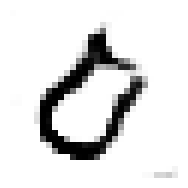

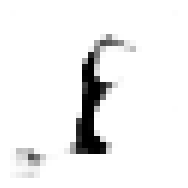

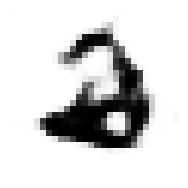

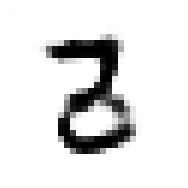

In [ ]:
model = keras.models.load_model('cgan_generator.h5')
# generate images
latent_points, labels = get_latent_vector(10, 100)
# specify labels
labels = np.asarray([x for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 2)

### Remarks:  This model is trained on just 20 epochs and we can see the result. we can get the better result by training it on more epochs but as the loss is BCE so there is great chance of Mode collapse on high epoch number , there will be fidelity but not diversity so its better to use the Wasserstein Loss with gradient penality or with gradient clipping